In [ ]:
!pip install torch-geometric torch-sparse torch-scatter

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd
import random
import copy
from torch_geometric.transforms import NormalizeFeatures
from torch.nn.utils import prune
from sklearn.metrics import roc_curve, auc
import numpy as np
from torch_geometric.utils import to_dense_adj, dense_to_sparse
import matplotlib.pyplot as plt

In [ ]:
# Model Definitions
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)

class GAT(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels*heads, out_channels, heads=1)
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)

class GraphSAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)


In [ ]:
class TriggerGenerator(nn.Module):
    def __init__(self, in_channels, hidden_channels, owner_id):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, in_channels)
        self.owner_id = owner_id

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = torch.sigmoid(self.conv2(x, edge_index))
        out = x.clone()
        out[:, -5:] = self.owner_id
        return out


In [ ]:
def load_dataset(name):
    return Planetoid(root=f'/tmp/{name}', name=name, transform=NormalizeFeatures())

In [ ]:
def calculate_metrics(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        true = data.y

        # Handle both original and watermarked data cases
        if hasattr(data, 'original_test_mask'):
            test_mask = data.original_test_mask
            # Pad test_mask to match pred/true shape if needed
            if test_mask.size(0) < pred.size(0):
                pad_len = pred.size(0) - test_mask.size(0)
                test_mask = torch.cat([test_mask, torch.zeros(pad_len, dtype=torch.bool, device=test_mask.device)])
        else:
            test_mask = data.test_mask

        metrics = {
            'accuracy': (pred[test_mask] == true[test_mask]).float().mean().item(),
            'precision': precision_score(true[test_mask].cpu(), pred[test_mask].cpu(), average='macro'),
            'recall': recall_score(true[test_mask].cpu(), pred[test_mask].cpu(), average='macro'),
            'f1': f1_score(true[test_mask].cpu(), pred[test_mask].cpu(), average='macro'),
            'wm_accuracy': None
        }

        if hasattr(data, 'trigger_nodes'):
            wm_mask = torch.zeros(data.num_nodes, dtype=torch.bool, device=data.x.device)
            wm_mask[data.trigger_nodes] = True
            wm_pred = pred[wm_mask]
            wm_true = true[wm_mask]
            metrics['wm_accuracy'] = (wm_pred == wm_true).float().mean().item() * 100

        return metrics


In [ ]:
def generate_trigger_graph(data, generator, target_model, num_triggers=50):
    with torch.no_grad():
        probs = F.softmax(target_model(data.x, data.edge_index), dim=1)

    selected_nodes = []
    for class_idx in range(probs.size(1)):
        class_nodes = torch.where(data.y == class_idx)[0]
        if len(class_nodes) > 0:
            selected_nodes.append(class_nodes[probs[class_nodes, class_idx].argmax()].item())

    trigger_features = generator(data.x, data.edge_index)
    trigger_nodes = list(range(data.num_nodes, data.num_nodes + num_triggers))

    adj = to_dense_adj(data.edge_index)[0]
    new_adj = torch.zeros((adj.size(0) + num_triggers, adj.size(1) + num_triggers), device=adj.device)
    new_adj[:adj.size(0), :adj.size(1)] = adj

    for i, trigger in enumerate(trigger_nodes):
        for node in selected_nodes:
            new_adj[node, trigger] = 1
            new_adj[trigger, node] = 1

    new_data = copy.deepcopy(data)
    new_data.x = torch.cat([data.x, trigger_features[:num_triggers]], dim=0)
    new_data.edge_index = dense_to_sparse(new_adj)[0]
    new_data.y = torch.cat([data.y, torch.zeros(num_triggers, dtype=torch.long, device=data.y.device)])

    # Preserve original test mask before adding triggers
    new_data.original_test_mask = data.test_mask.clone()

    # Add trigger information
    new_data.trigger_nodes = trigger_nodes
    new_data.selected_nodes = selected_nodes
    new_data.trigger_mask = torch.zeros(new_data.num_nodes, dtype=torch.bool, device=data.x.device)
    new_data.trigger_mask[trigger_nodes] = True

    return new_data

In [ ]:
def bi_level_optimization(target_model, generator, data, epochs=100, inner_steps=5):
    optimizer_model = torch.optim.Adam(target_model.parameters(), lr=0.01)
    optimizer_gen = torch.optim.Adam(generator.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        for _ in range(inner_steps):
            optimizer_model.zero_grad()
            trigger_data = generate_trigger_graph(data, generator, target_model)

            out_clean = target_model(data.x, data.edge_index)
            out_trigger = target_model(trigger_data.x, trigger_data.edge_index)

            clean_loss = criterion(out_clean[data.train_mask], data.y[data.train_mask])
            trigger_loss = criterion(out_trigger[trigger_data.trigger_mask],
                                  trigger_data.y[trigger_data.trigger_mask])

            total_loss = clean_loss + trigger_loss
            total_loss.backward()
            optimizer_model.step()

        optimizer_gen.zero_grad()
        trigger_data = generate_trigger_graph(data, generator, target_model)

        orig_features = data.x[trigger_data.selected_nodes]
        trigger_features = trigger_data.x[trigger_data.trigger_nodes]
        sim_loss = -F.cosine_similarity(orig_features.unsqueeze(1),
                                     trigger_features.unsqueeze(0), dim=-1).mean()

        out = target_model(trigger_data.x, trigger_data.edge_index)
        trigger_loss = criterion(out[trigger_data.trigger_mask],
                               trigger_data.y[trigger_data.trigger_mask])

        owner_loss = F.binary_cross_entropy(
            trigger_data.x[trigger_data.trigger_nodes, -5:],
            generator.owner_id.expand(len(trigger_data.trigger_nodes), 5)
        )

        total_gen_loss = 0.4*sim_loss + 0.4*trigger_loss + 0.2*owner_loss
        total_gen_loss.backward()
        optimizer_gen.step()


In [ ]:
def train_model(model, data, epochs=200, wm_weight=0.2):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)

        main_loss = criterion(out[data.train_mask], data.y[data.train_mask])

        wm_loss = 0
        if hasattr(data, 'trigger_nodes'):
            trigger_mask = data.trigger_mask
            wm_loss = criterion(out[trigger_mask], data.y[trigger_mask])

        loss = (1-wm_weight)*main_loss + wm_weight*wm_loss
        loss.backward()
        optimizer.step()

    return calculate_metrics(model, data)


In [ ]:
def run_comparison():
    datasets = ['Cora', 'Pubmed']
    models = {
        'GCN': lambda d: GCN(d.num_features, 128, d.num_classes),
        'GAT': lambda d: GAT(d.num_features, 64, d.num_classes),
        'GraphSAGE': lambda d: GraphSAGE(d.num_features, 128, d.num_classes)
    }

    results = []

    for dataset_name in datasets:
        dataset = load_dataset(dataset_name)
        data = dataset[0]

        indices = torch.randperm(data.num_nodes)
        data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
        data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
        data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
        data.train_mask[indices[:int(0.6*data.num_nodes)]] = True
        data.val_mask[indices[int(0.6*data.num_nodes):int(0.8*data.num_nodes)]] = True
        data.test_mask[indices[int(0.8*data.num_nodes):]] = True

        for model_name, model_fn in models.items():
            original_model = model_fn(dataset)
            orig_metrics = train_model(original_model, data, wm_weight=0.0)

            generator = TriggerGenerator(dataset.num_features, 64, torch.tensor([0.1, 0.3, 0.5, 0.7, 0.9]))
            wm_model = model_fn(dataset)
            bi_level_optimization(wm_model, generator, data)

            trigger_data = generate_trigger_graph(data, generator, wm_model)
            wm_metrics = calculate_metrics(wm_model, trigger_data)

            results.append({
                'Dataset': dataset_name,
                'Model': model_name,
                'Orig_Acc': orig_metrics['accuracy']*100,
                'WM_Acc': wm_metrics['accuracy']*100,
                'Orig_Prec': orig_metrics['precision']*100,
                'WM_Prec': wm_metrics['precision']*100,
                'Orig_Rec': orig_metrics['recall']*100,
                'WM_Rec': wm_metrics['recall']*100,
                'Orig_F1': orig_metrics['f1']*100,
                'WM_F1': wm_metrics['f1']*100
            })

    print("\nModel performance (original model | watermarked model)")
    print("| Dataset |   Model   |  Accuracy (%)  | Precision (%) |   Recall (%)  | F1-score (%)  |")
    print("|---------|-----------|----------------|---------------|---------------|---------------|")

    for dataset in datasets:
        for i, model in enumerate(models.keys()):
            res = next(r for r in results if r['Dataset'] == dataset and r['Model'] == model)
            if i == 0:
                print(f"| {dataset:<7} | {model:<9} | {res['Orig_Acc']:.2f} | {res['WM_Acc']:.2f} | {res['Orig_Prec']:.2f} | {res['WM_Prec']:.2f} | {res['Orig_Rec']:.2f} | {res['WM_Rec']:.2f} | {res['Orig_F1']:.2f} | {res['WM_F1']:.2f} |")
            else:
                print(f"|         | {model:<9} | {res['Orig_Acc']:.2f} | {res['WM_Acc']:.2f} | {res['Orig_Prec']:.2f} | {res['WM_Prec']:.2f} | {res['Orig_Rec']:.2f} | {res['WM_Rec']:.2f} | {res['Orig_F1']:.2f} | {res['WM_F1']:.2f} |")

    wm_table = {'Dataset': [], 'GCN': [], 'GAT': [], 'GraphSAGE': []}

    for dataset in datasets:
        wm_table['Dataset'].append(dataset)
        for model in models.keys():
            res = next(r for r in results if r['Dataset'] == dataset and r['Model'] == model)
            wm_acc = res.get('WM_Acc', 0.0)
            wm_table[model].append(f"{wm_acc:.2f}")

    print("\nWatermark accuracy table (%)")
    print("| Dataset |  GCN  |  GAT  | GraphSAGE |")
    print("|---------|-------|-------|------------|")
    for i in range(len(wm_table['Dataset'])):
        print(f"| {wm_table['Dataset'][i]:<7} | {wm_table['GCN'][i]:>5} | {wm_table['GAT'][i]:>5} | {wm_table['GraphSAGE'][i]:>10} |")


In [ ]:
def run_finetune_experiment():
    datasets = ['Cora', 'Pubmed']
    models = {
        'GCN': lambda d: GCN(d.num_features, 128, d.num_classes),
        'GAT': lambda d: GAT(d.num_features, 64, d.num_classes),
        'GraphSAGE': lambda d: GraphSAGE(d.num_features, 128, d.num_classes)
    }

    results = {model: {dataset: [] for dataset in datasets} for model in models.keys()}

    for dataset_name in datasets:
        dataset = load_dataset(dataset_name)
        data = dataset[0]

        indices = torch.randperm(data.num_nodes)
        data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
        data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
        data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
        data.train_mask[indices[:int(0.6*data.num_nodes)]] = True
        data.val_mask[indices[int(0.6*data.num_nodes):int(0.8*data.num_nodes)]] = True
        data.test_mask[indices[int(0.8*data.num_nodes):]] = True

        test_indices = data.test_mask.nonzero().squeeze()
        ft_indices = test_indices[:int(0.6*len(test_indices))]
        eval_indices = test_indices[int(0.6*len(test_indices)):]

        ft_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
        eval_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
        ft_mask[ft_indices] = True
        eval_mask[eval_indices] = True

        for model_name, model_fn in models.items():
            generator = TriggerGenerator(dataset.num_features, 64, torch.tensor([0.1, 0.3, 0.5, 0.7, 0.9]))
            wm_model = model_fn(dataset)
            bi_level_optimization(wm_model, generator, data)

            optimizer = torch.optim.Adam(wm_model.parameters(), lr=0.005)
            criterion = nn.CrossEntropyLoss()

            wm_accuracies = []

            for epoch in range(101):
                trigger_data = generate_trigger_graph(data, generator, wm_model)

                pad_len = trigger_data.num_nodes - ft_mask.size(0)
                padded_ft_mask = ft_mask
                if pad_len > 0:
                    padded_ft_mask = torch.cat([
                        ft_mask,
                        torch.zeros(pad_len, dtype=torch.bool, device=ft_mask.device)
                    ])

                wm_model.train()
                optimizer.zero_grad()
                out = wm_model(trigger_data.x, trigger_data.edge_index)
                loss = criterion(out[padded_ft_mask], trigger_data.y[padded_ft_mask])
                loss.backward()
                optimizer.step()

                if epoch % 10 == 0:
                    wm_model.eval()
                    with torch.no_grad():
                        pred = wm_model(trigger_data.x, trigger_data.edge_index).argmax(dim=1)
                        if hasattr(trigger_data, 'trigger_nodes'):
                            wm_mask = torch.zeros(trigger_data.num_nodes, dtype=torch.bool)
                            wm_mask[trigger_data.trigger_nodes] = True
                            wm_acc = (pred[wm_mask] == trigger_data.y[wm_mask]).float().mean().item() * 100
                            wm_accuracies.append(wm_acc)

            results[model_name][dataset_name] = wm_accuracies

    # Print summary table
    print("\nFinal watermark accuracy after fine-tuning (%):")
    print("| Dataset |  GCN   |  GAT   | GraphSAGE |")
    print("|---------|--------|--------|-----------|")
    for dataset in datasets:
        gcn_acc = results['GCN'][dataset][-1]
        gat_acc = results['GAT'][dataset][-1]
        sage_acc = results['GraphSAGE'][dataset][-1]
        print(f"| {dataset:<7} | {gcn_acc:6.2f} | {gat_acc:6.2f} | {sage_acc:9.2f} |")

    plt.figure(figsize=(15, 4))
    for i, model_name in enumerate(models.keys()):
        plt.subplot(1, 3, i+1)
        for dataset in datasets:
            plt.plot(
                range(0, 101, 10),
                results[model_name][dataset],
                marker='o', linestyle='-', label=dataset
            )
        plt.title(f'({chr(97+i)}) {model_name}')
        plt.xlabel('Epoch')
        plt.ylabel('Watermark Accuracy (%)')
        plt.ylim(90, 100)
        plt.grid(True)
        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if i == 0:
            plt.legend()
    plt.tight_layout()
    plt.savefig('fine_tuning_robustness.png')
    plt.show()


In [ ]:
def run_pruning_experiment():
    datasets = ['Cora', 'Pubmed']
    models = {
        'GCN': lambda d: GCN(d.num_features, 128, d.num_classes),
        'GAT': lambda d: GAT(d.num_features, 64, d.num_classes),
        'GraphSAGE': lambda d: GraphSAGE(d.num_features, 128, d.num_classes)
    }

    pruning_rates = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    results = {model: {dataset: [] for dataset in datasets} for model in models.keys()}

    for dataset_name in datasets:
        dataset = load_dataset(dataset_name)
        data = dataset[0]

        indices = torch.randperm(data.num_nodes)
        data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
        data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
        data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
        data.train_mask[indices[:int(0.6*data.num_nodes)]] = True
        data.val_mask[indices[int(0.6*data.num_nodes):int(0.8*data.num_nodes)]] = True
        data.test_mask[indices[int(0.8*data.num_nodes):]] = True

        for model_name, model_fn in models.items():
            generator = TriggerGenerator(dataset.num_features, 64, torch.tensor([0.1, 0.3, 0.5, 0.7, 0.9]))
            wm_model = model_fn(dataset)
            bi_level_optimization(wm_model, generator, data)
            original_state = copy.deepcopy(wm_model.state_dict())

            for rate in pruning_rates:
                wm_model = model_fn(dataset)
                wm_model.load_state_dict(original_state)

                parameters_to_prune = []
                for name, module in wm_model.named_modules():
                    if isinstance(module, (GCNConv, GATConv, SAGEConv, nn.Linear)):
                        if hasattr(module, 'weight'):
                            parameters_to_prune.append((module, 'weight'))

                if parameters_to_prune:
                    for module, param_name in parameters_to_prune:
                        prune.l1_unstructured(module, name=param_name, amount=rate)
                        prune.remove(module, param_name)

                # Regenerate trigger graph AFTER pruning
                trigger_data = generate_trigger_graph(data, generator, wm_model)

                wm_model.eval()
                with torch.no_grad():
                    pred = wm_model(trigger_data.x, trigger_data.edge_index).argmax(dim=1)
                    if hasattr(trigger_data, 'trigger_nodes'):
                        wm_mask = torch.zeros(trigger_data.num_nodes, dtype=torch.bool)
                        wm_mask[trigger_data.trigger_nodes] = True
                        wm_acc = (pred[wm_mask] == trigger_data.y[wm_mask]).float().mean().item() * 100
                        results[model_name][dataset_name].append(wm_acc)

    print("\nWatermark accuracy at different pruning rates (%):")
    print("| Model     | Dataset |  0%  | 10%  | 30%  | 50%  | 70%  | 90%  |")
    print("|-----------|---------|------|------|------|------|------|")
    for model_name in models.keys():
        for dataset in datasets:
            accs = results[model_name][dataset]
            print(f"| {model_name:<9} | {dataset:<7} | {accs[0]:4.1f} | {accs[1]:4.1f} | {accs[3]:4.1f} | {accs[5]:4.1f} | {accs[7]:4.1f} | {accs[9]:4.1f} |")

    # Plot
    plt.figure(figsize=(15, 4))
    for i, model_name in enumerate(models.keys()):
        plt.subplot(1, 3, i+1)
        for dataset in datasets:
            plt.plot(
                [p * 100 for p in pruning_rates],
                results[model_name][dataset],
                marker='o', linestyle='-', label=dataset
            )
        plt.title(f'({chr(97+i)}) {model_name}')
        plt.xlabel('Pruning Rate (%)')
        plt.ylabel('Watermark Accuracy (%)')
        plt.ylim(50, 100)
        plt.tick_params(top=False, right=False)  # no extra lines
        if i == 0:
            plt.legend()
        plt.grid(True)
    plt.tight_layout()
    plt.savefig('pruning_robustness.png')
    plt.show()


In [ ]:
if __name__ == "__main__":
    run_comparison()

Processing...
Done!
Processing...
Done!



Model performance (original model | watermarked model)
| Dataset |   Model   |  Accuracy (%)  | Precision (%) |   Recall (%)  | F1-score (%)  |
|---------|-----------|----------------|---------------|---------------|---------------|
| Cora    | GCN       | 85.61 | 81.92 | 85.55 | 82.12 | 84.08 | 81.24 | 84.72 | 81.56 |
|         | GAT       | 85.42 | 83.58 | 85.63 | 83.91 | 84.15 | 82.74 | 84.75 | 83.09 |
|         | GraphSAGE | 86.35 | 84.50 | 86.93 | 84.60 | 84.91 | 83.53 | 85.78 | 83.99 |
| Pubmed  | GCN       | 86.74 | 86.49 | 86.20 | 85.61 | 86.18 | 86.02 | 86.11 | 85.81 |
|         | GAT       | 85.90 | 86.74 | 85.28 | 86.11 | 85.31 | 86.17 | 85.12 | 86.14 |
|         | GraphSAGE | 88.56 | 87.04 | 88.03 | 86.47 | 88.18 | 86.71 | 88.10 | 86.58 |

Watermark accuracy table (%)
| Dataset |  GCN  |  GAT  | GraphSAGE |
|---------|-------|-------|------------|
| Cora    | 81.92 | 83.58 |      84.50 |
| Pubmed  | 86.49 | 86.74 |      87.04 |


Processing...
Done!
Processing...
Done!



Final watermark accuracy after fine-tuning (%):
| Dataset |  GCN   |  GAT   | GraphSAGE |
|---------|--------|--------|-----------|
| Cora    |   0.00 |   0.00 |    100.00 |
| Pubmed  | 100.00 | 100.00 |    100.00 |


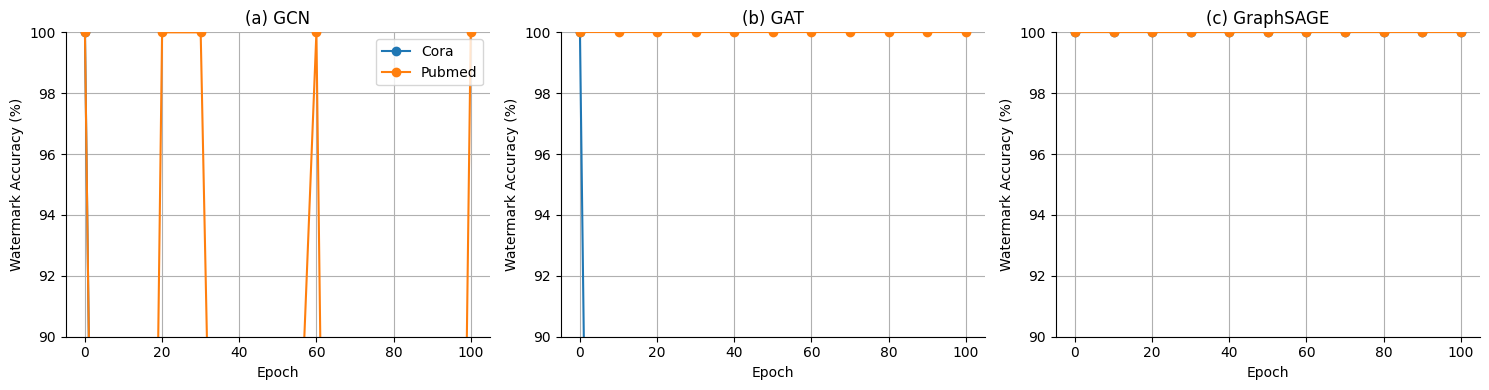

In [ ]:
run_finetune_experiment()


Watermark accuracy at different pruning rates (%):
| Model     | Dataset |  0%  | 10%  | 30%  | 50%  | 70%  | 90%  |
|-----------|---------|------|------|------|------|------|
| GCN       | Cora    | 100.0 | 100.0 | 100.0 | 100.0 | 100.0 | 100.0 |
| GCN       | Pubmed  | 100.0 | 100.0 | 100.0 | 100.0 | 100.0 | 100.0 |
| GAT       | Cora    | 100.0 | 100.0 | 100.0 | 100.0 | 100.0 | 100.0 |
| GAT       | Pubmed  | 100.0 | 100.0 | 100.0 | 100.0 | 100.0 | 100.0 |
| GraphSAGE | Cora    | 100.0 | 100.0 | 100.0 | 100.0 | 100.0 | 100.0 |
| GraphSAGE | Pubmed  | 100.0 | 100.0 | 100.0 | 100.0 | 100.0 | 100.0 |


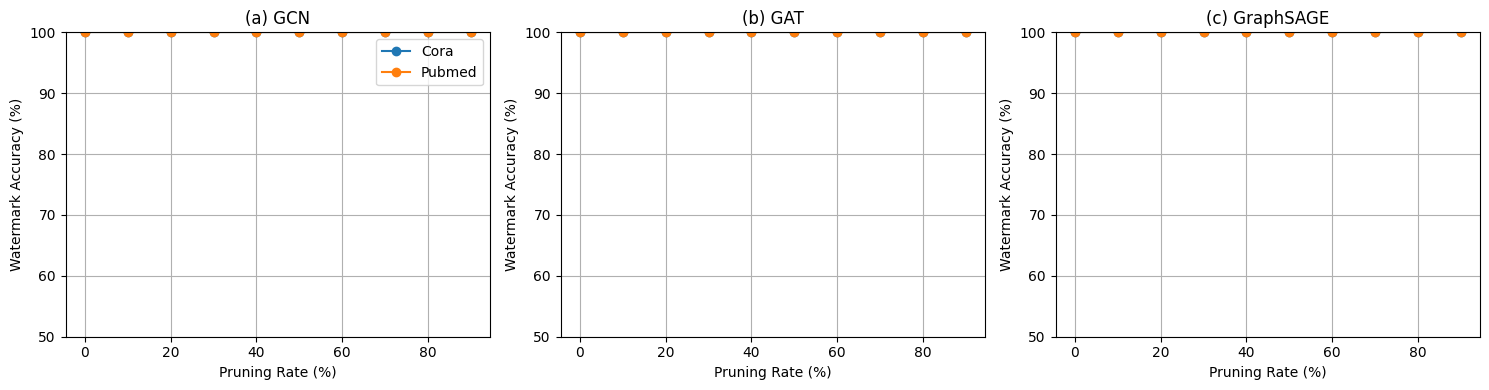

In [ ]:
run_pruning_experiment()

In [ ]:
def run_evasion_attack():
    datasets = ['Cora', 'Pubmed']
    models = {
        'GCN': lambda d: GCN(d.num_features, 128, d.num_classes),
    }

    plt.figure(figsize=(8, 6))
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (area = 0.5)')

    for dataset_name in datasets:
        dataset = load_dataset(dataset_name)
        data = dataset[0]

        # Our Method
        generator = TriggerGenerator(dataset.num_features, 64, torch.tensor([0.1, 0.3, 0.5, 0.7, 0.9]))
        model = models['GCN'](dataset)
        bi_level_optimization(model, generator, data)
        trigger_data = generate_trigger_graph(data, generator, model)

        cosine_sims = []
        is_trigger = []
        for i in range(trigger_data.num_nodes):
            if i in trigger_data.trigger_nodes:
                is_trigger.append(1)
                neighbors = trigger_data.edge_index[1][trigger_data.edge_index[0] == i]
                if len(neighbors) > 0:
                    neighbor_features = trigger_data.x[neighbors]
                    sim = F.cosine_similarity(trigger_data.x[i].unsqueeze(0), neighbor_features).mean().item()
                else:
                    sim = 0.0
            else:
                is_trigger.append(0)
                neighbors = trigger_data.edge_index[1][trigger_data.edge_index[0] == i]
                if len(neighbors) > 0:
                    neighbor_features = trigger_data.x[neighbors]
                    sim = F.cosine_similarity(trigger_data.x[i].unsqueeze(0), neighbor_features).mean().item()
                else:
                    sim = 1.0
            cosine_sims.append(sim)

        y_true = np.array(is_trigger)
        y_scores = 1 - np.array(cosine_sims)
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Ours on {dataset_name} (area = {roc_auc:.3f})')

        # GTA Baseline
        gta_data = copy.deepcopy(data)
        trigger_nodes = random.sample(range(data.num_nodes), 50)
        feature_dim = data.x.size(1)
        for node in trigger_nodes:
            gta_data.x[node] = torch.zeros_like(gta_data.x[node])
            gta_data.x[node, :5] = 5.0
            gta_data.y[node] = 0

        adj = to_dense_adj(gta_data.edge_index)[0]
        for i in trigger_nodes:
            for j in trigger_nodes:
                if i != j:
                    adj[i,j] = 1
        gta_data.edge_index = dense_to_sparse(adj)[0]

        gta_model = models['GCN'](dataset)
        train_model(gta_model, gta_data)

        gta_scores = []
        degrees = torch.zeros(gta_data.num_nodes)
        for i in range(gta_data.num_nodes):
            degrees[i] = (gta_data.edge_index[0] == i).sum()

        for i in range(gta_data.num_nodes):
            neighbors = gta_data.edge_index[1][gta_data.edge_index[0] == i]
            if len(neighbors) > 0:
                neighbor_feats = gta_data.x[neighbors]
                feat_consistency = 1 - F.cosine_similarity(
                    gta_data.x[i].unsqueeze(0), neighbor_feats).mean().item()
            else:
                feat_consistency = 0
            gta_scores.append(degrees[i].item() * feat_consistency)

        gta_y_true = np.array([1 if i in trigger_nodes else 0 for i in range(gta_data.num_nodes)])
        gta_fpr, gta_tpr, _ = roc_curve(gta_y_true, gta_scores)
        gta_auc = auc(gta_fpr, gta_tpr)
        plt.plot(gta_fpr, gta_tpr, '-.', label=f'GTA on {dataset_name} (area = {gta_auc:.3f})')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Trigger Node Detection')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.savefig('evasion_roc_curve.png')
    plt.show()

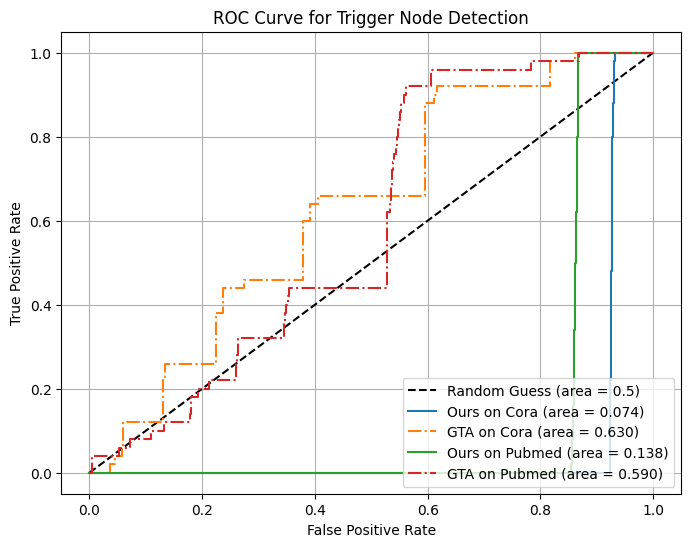

In [ ]:
run_evasion_attack()

In [ ]:
def run_fraudulent_declaration():
    dataset = load_dataset('Cora')
    data = dataset[0]
    indices = torch.randperm(data.num_nodes)
    data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    data.train_mask[indices[:int(0.6*data.num_nodes)]] = True
    data.val_mask[indices[int(0.6*data.num_nodes):int(0.8*data.num_nodes)]] = True
    data.test_mask[indices[int(0.8*data.num_nodes):]] = True

    # Create 5 watermarked models with different owner IDs
    models = []
    generators = []
    owner_ids = [
        torch.tensor([0.1, 0.3, 0.5, 0.7, 0.9]),
        torch.tensor([0.9, 0.7, 0.5, 0.3, 0.1]),
        torch.tensor([0.2, 0.4, 0.6, 0.8, 1.0]),
        torch.tensor([1.0, 0.8, 0.6, 0.4, 0.2]),
        torch.tensor([0.5, 0.5, 0.5, 0.5, 0.5])
    ]

    for owner_id in owner_ids:
        generator = TriggerGenerator(dataset.num_features, 64, owner_id)
        model = GAT(dataset.num_features, 64, dataset.num_classes)
        bi_level_optimization(model, generator, data)
        models.append(model)
        generators.append(generator)

    # Create verification matrix
    verification_matrix = torch.zeros((5, 5))
    for i, gen in enumerate(generators):
        for j, model in enumerate(models):
            trigger_data = generate_trigger_graph(data, gen, model)
            with torch.no_grad():
                pred = model(trigger_data.x, trigger_data.edge_index).argmax(dim=1)
                wm_mask = torch.zeros(trigger_data.num_nodes, dtype=torch.bool)
                wm_mask[trigger_data.trigger_nodes] = True
                wm_acc = (pred[wm_mask] == trigger_data.y[wm_mask]).float().mean().item() * 100
                verification_matrix[i,j] = wm_acc

    print("\nFraudulent Declaration Test Results (% accuracy):")
    print("| Model | Gen 1 | Gen 2 | Gen 3 | Gen 4 | Gen 5 |")
    print("|-------|-------|-------|-------|-------|-------|")
    for i in range(5):
        print(f"| Model {i+1} | {verification_matrix[0,i]:5.1f} | {verification_matrix[1,i]:5.1f} | {verification_matrix[2,i]:5.1f} | {verification_matrix[3,i]:5.1f} | {verification_matrix[4,i]:5.1f} |")

    # Plot heatmap
    plt.figure(figsize=(8, 6))
    plt.imshow(verification_matrix, cmap='viridis', vmin=0, vmax=100)
    plt.colorbar(label='Watermark Accuracy (%)')
    plt.xticks(range(5), [f'Gen {i+1}' for i in range(5)])
    plt.yticks(range(5), [f'Model {i+1}' for i in range(5)])
    plt.title("Fraudulent Declaration Attack Results")
    plt.xlabel("Generator Used for Verification")
    plt.ylabel("Target Model")
    plt.savefig('fraudulent_declaration.png')
    plt.show()


Fraudulent Declaration Test Results (% accuracy):
| Model | Gen 1 | Gen 2 | Gen 3 | Gen 4 | Gen 5 |
|-------|-------|-------|-------|-------|-------|
| Model 1 | 100.0 | 100.0 | 100.0 | 100.0 | 100.0 |
| Model 2 |   0.0 | 100.0 |   0.0 |   0.0 |   0.0 |
| Model 3 | 100.0 | 100.0 | 100.0 | 100.0 | 100.0 |
| Model 4 | 100.0 | 100.0 | 100.0 | 100.0 | 100.0 |
| Model 5 | 100.0 | 100.0 | 100.0 |  30.0 | 100.0 |


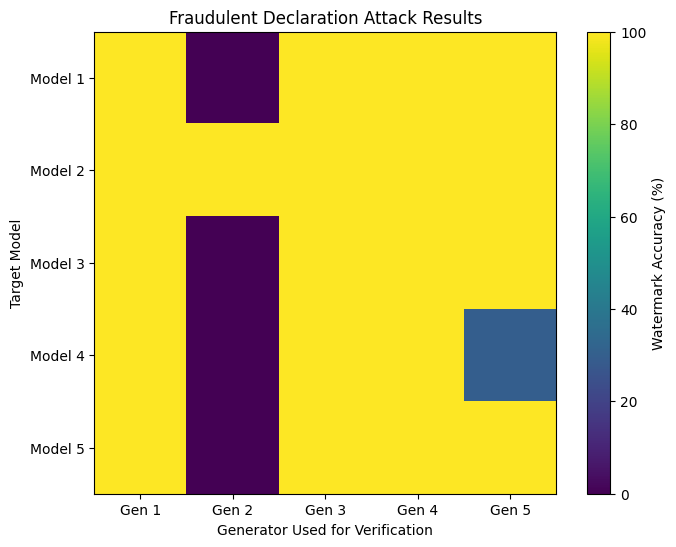

In [ ]:
run_fraudulent_declaration()